# Préparation des données avec ELMO à la place de Word2Vec

In [1]:
import pandas as pd
import numpy as np

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
dataset = pd.read_csv('data/train_cap2018.csv')

In [3]:
from sklearn.model_selection import train_test_split
test_size = 0.2
random_state = 42

In [4]:
train, test = train_test_split(dataset, test_size=test_size, random_state=random_state, shuffle=True, stratify=dataset.loc[:,'level1'])
print(train.shape)
print(test.shape)

(21848, 60)
(5462, 60)


In [5]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
print(X_train.shape)
print(y_train.shape)

(21848, 59)
(21848,)


In [6]:
y_train = y_train.replace({"A1": 0, "A2" : 1, "B1" : 2, "B2" : 3, "C1" : 4, "C2" : 5})

In [7]:
#X_train_fulltext = X_train.loc[:, 'fulltext'].iloc[:10]
#y_train = y_train[:10]
#print(X_train_fulltext)

X_train_fulltext = X_train.loc[:, 'fulltext']

In [8]:
training_size = 0.7

X_train = X_train_fulltext[0:int(X_train_fulltext.shape[0]*training_size)]
y_train_full = y_train
y_train = y_train_full[0:int(X_train_fulltext.shape[0]*training_size)]

X_val = X_train_fulltext[int(X_train_fulltext.shape[0]*training_size):]
y_val = y_train_full[int(X_train_fulltext.shape[0]*training_size):]

In [9]:
y_train = np.array(y_train.reset_index().iloc[:,1])
y_val = np.array(y_val.reset_index().iloc[:,1])

In [10]:
print(X_val.shape)
print(y_val.shape)
print(X_train.shape)
print(y_train.shape)

(6555,)
(6555,)
(15293,)
(15293,)


# Programmation avec ELMO

Récupération d'un module ELMO déjà entrainé.

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
def get_next_batch_X(X, iteration, batch_size):
    X_batch = X[iteration*batch_size:(iteration+1)*batch_size]
    seq_lengths = []
    i = 0
    for text in X_batch:
        tokens = text.split()
        seq_lengths.append(len(tokens))
        i = i + 1
    return X_batch, tuple(seq_lengths)

def get_next_batch_y(y, iteration, batch_size):
    y_batch = y[iteration*batch_size:(iteration+1)*batch_size]
    return y_batch
print(get_next_batch_X(X_train, 0, 3))
print(get_next_batch_y(y_train, 0, 3))
print(type(get_next_batch_y(y_train, 0, 3)))

(17424    \n\n      Hello, Why don't you buy the orange ...
18934    \n\n      Good evening, how are you ? I'm fine...
4305     \n\n      CAREER PLAN Name : Jean-Philippe BLA...
Name: fulltext, dtype: object, (40, 14, 96))
[0 0 2]
<class 'numpy.ndarray'>


In [28]:
def create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_neurons=500, activation=tf.nn.relu, 
                               dropout_in=0, dropout_out=0, class_weights=[1, 1, 1, 1, 1, 1], learning_rate=0.001, 
                               n_epochs=100, batch_size=200, max_checks_without_progress=3):
    
    tf.reset_default_graph()
    
    X = tf.placeholder(dtype=tf.string, shape=[None], name="X")
    y = tf.placeholder(tf.int64, shape=[None], name="y")
    seq_lengths = tf.placeholder(tf.int64, shape=[None], name="seq_lengths")
    
    elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=False)
    X_elmo = elmo(X, signature="default", as_dict=True)["elmo"]
    #X_elmo = tf.cast(X_elmo, tf.float16)
    #sequence_length = tf.shape(X_elmo)[1]*tf.ones(tf.shape(X_elmo)[0], dtype=tf.int32)
    
    dropout_in_placeholder = tf.placeholder_with_default(tf.constant(0.0, dtype=tf.float32), ())
    dropout_out_placeholder = tf.placeholder_with_default(tf.constant(0.0, dtype=tf.float32), ())
    
    basic_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=activation)
    basic_cell = tf.contrib.rnn.DropoutWrapper(basic_cell, input_keep_prob=1-dropout_in_placeholder, output_keep_prob=1-dropout_out_placeholder, dtype=tf.float32)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X_elmo, sequence_length=seq_lengths, dtype=tf.float32)

    logits = tf.layers.dense(inputs=states, units=n_outputs, name="logits")
    inference = tf.nn.softmax(logits, name="inference")

    with tf.name_scope("loss"):
        #loss = cost(inference, y)

        class_weights_tf = tf.constant(class_weights)
        weights = tf.gather(class_weights_tf, y)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits, weights=weights)
        #xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y) #ancienne version (sans poids)
        #loss = tf.reduce_mean(xentropy, name="loss")

    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(tf.cast(logits, tf.float32), y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    summary_writer = tf.summary.FileWriter("./summary", tf.get_default_graph())

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    n_batches_per_epoch = X_train.shape[0] // batch_size
    print("Nombre de batchs par epoch =", n_batches_per_epoch)
    
    best_loss = np.infty
    checks_without_progress = 0
    early_stopping = False
    if False:
        with tf.Session() as sess:
            init.run()
            for epoch in range(n_epochs):
                for iteration in range(n_batches_per_epoch):
                    X_batch, seq_len = get_next_batch_X(X_train, iteration, batch_size)
                    y_batch = y_train[iteration*batch_size:(iteration+1)*batch_size]
                    #print(seq_len)
                    sess.run(training_op, feed_dict={X: X_batch, y: y_batch, seq_lengths: seq_len, dropout_in_placeholder: dropout_in, dropout_out_placeholder: dropout_out})
                    #print(sess.run(X_elmo, feed_dict={X: X_batch, y: y_batch, dropout_in_placeholder: dropout_in, dropout_out_placeholder: dropout_out}))
                    if (iteration+1)%10==0:
                        print("Batch n°", iteration+1)
                    if (iteration+1)%100==0:
                        # attention l'évaluation du coût est faite en faisant une moyenne de moyennes,
                        # il faut donc que nb_examples_to_evaluate soit un multiple de batch_size_loss_eval
                        nb_examples_to_evaluate = np.amin([1000, X_train.shape[0], X_val.shape[0]])
                        batch_size_loss_eval = 25

                        i=0
                        k=0
                        loss_train=0
                        while i < nb_examples_to_evaluate:
                            X_batch, seq_len = get_next_batch_X(X_train, k, batch_size_loss_eval)
                            y_batch = get_next_batch_y(y_train, k, batch_size_loss_eval)
                            temp = loss.eval(feed_dict={X: X_batch, y: y_batch, seq_lengths: seq_len})
                            #print(temp)
                            loss_train = loss_train + temp
                            i = i + batch_size_loss_eval
                            k = k + 1
                        #print(loss_train)
                        #print(k)
                        loss_train = loss_train / k
                        print(epoch, "Loss training on", nb_examples_to_evaluate, "examples:", loss_train)

                        i=0
                        k=0
                        loss_val=0
                        while i < nb_examples_to_evaluate:
                            X_batch, seq_len = get_next_batch_X(X_val, k, batch_size_loss_eval)
                            y_batch = get_next_batch_y(y_val, k, batch_size_loss_eval)
                            temp = loss.eval(feed_dict={X: X_batch, y: y_batch, seq_lengths: seq_len})
                            loss_val = loss_val + temp
                            i = i + batch_size_loss_eval
                            k = k + 1
                        loss_val = loss_val / k
                        print(epoch, "Loss validation on", nb_examples_to_evaluate, "examples:", loss_val)

                        if loss_val < best_loss:
                            save_path = saver.save(sess, "./natural_language_classifier.ckpt")
                            best_loss = loss_val
                            checks_without_progress = 0
                        else:
                            checks_without_progress += 1
                            if checks_without_progress >= MAX_CHECKS_WITHOUT_PROGRESS:
                                print("Early stopping!")
                                early_stopping = True
                                break
                    if early_stopping:
                        break
            
    return inference, X, seq_lengths

In [29]:
n_steps = 450 #taille maximale des textes (rendue fixe)
print("Nombre maximal de mots par texte (fixe) =", n_steps)
n_neurons = 5000
activation = tf.nn.relu
n_outputs = 6
class_weights = [1, 1, 1, 1, 1, 1] #poids de la fonction de coût
learning_rate = 0.001

n_epochs = 100
batch_size = 30

MAX_CHECKS_WITHOUT_PROGRESS = 10

Nombre maximal de mots par texte (fixe) = 450


In [30]:
inference, X, seq_lengths = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_neurons=n_neurons, 
                                          activation=activation, class_weights=class_weights,
                                           learning_rate=learning_rate, n_epochs=n_epochs, 
                                          batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

#0.6 sur les ensembles d'entrainement et d'évaluation avec 500 neurones

INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with aggregation/weights
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with bilm/CNN/W_cnn_1
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/0eadd30f548cbfd3065119697ded6bb381668285/variables/variables' with bilm/CNN/W_cnn_2
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_3:0 from checkp

Nombre de batchs par epoch = 509


In [31]:
costs = np.array([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])
names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

In [32]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
from sklearn.metrics import confusion_matrix
print_confusion = True
def cost(y_pred, y_true, normalize=True):
    confusion = confusion_matrix(y_true, y_pred)
    res = (1/y_true.shape[0]) * np.sum(np.multiply(costs, confusion))
    
    if print_confusion:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, normalize=normalize, title='Normalized confusion matrix')

        plt.show()
    return res

INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[0.96 0.03 0.01 0.   0.   0.  ]
 [0.03 0.91 0.06 0.01 0.   0.  ]
 [0.01 0.02 0.94 0.03 0.01 0.  ]
 [0.01 0.02 0.1  0.84 0.04 0.  ]
 [0.   0.06 0.19 0.07 0.69 0.  ]
 [0.   0.07 0.07 0.14 0.71 0.  ]]


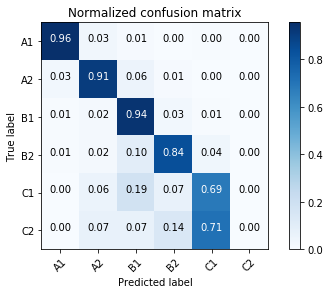

0.26361556064073227


In [35]:
print_confusion = True
batch_size = 50

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    i=0
    iteration=0
    y_pred = []
    while i < X_val.shape[0]:
        X_batch, seq_len = get_next_batch_X(X_val, iteration, batch_size)
        #print(X_batch)
        temp = sess.run(inference, feed_dict={X: X_batch, seq_lengths: seq_len})
        #print(temp)
        y_pred.extend(np.argmax(temp, axis=1))
        #print(y_pred)
        i = i + batch_size
        iteration = iteration + 1
print(cost(y_pred, y_val))